# Mounting google drive

In [0]:
#!pip install tensorflow--gpu==2.0.0-alpha0

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load modules

In [0]:
from __future__ import print_function, unicode_literals

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import re
import nltk
import unicodedata

import tensorflow as tf
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

print(tf.__version__)

# Load and explore data

In [0]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/text-generation/text-generation-word/nips.csv')
df = df[df['Abstract'] != "Abstract Missing"]
df = df.reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4933 entries, 0 to 4932
Data columns (total 3 columns):
Year        4933 non-null int64
Title       4933 non-null object
Abstract    4933 non-null object
dtypes: int64(1), object(2)
memory usage: 115.7+ KB


In [0]:
# Select a small dataset
df_small = df.iloc[:1500]
df_small.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 3 columns):
Year        1500 non-null int64
Title       1500 non-null object
Abstract    1500 non-null object
dtypes: int64(1), object(2)
memory usage: 35.3+ KB


In [0]:
text = df_small['Abstract']
text.head()

0    Up-propagation is an algorithm for inverting ...
1    We have constructed an inexpensive video based...
2    Non-negative matrix factorization (NMF) has pr...
3    Spike-triggered averaging techniques are effec...
4    We consider continuous state, continuous actio...
Name: Abstract, dtype: object

In [0]:
def print_text(index, Series):
    example = Series[Series.index == index].values[0]
    if len(example) > 0:
        print(example)
    else:
      print('Empty!')

In [0]:
print_text(0,text)
print_text(10,text)
print_text(20, text)

Up-propagation is an algorithm for inverting and learning neural network
generative models Sensory input is processed by inverting a model that
generates patterns from hidden variables using topdown connections
The inversion process is iterative utilizing a negative feedback loop that
depends on an error signal propagated by bottomup connections The
error signal is also used to learn the generative model from examples
The algorithm is benchmarked against principal component analysis in
experiments on images of handwritten digits.
Computational models of visual cortex, and in particular those based on sparse coding, have enjoyed much recent attention. Despite this currency, the question of how sparse or how over-complete a sparse representation should be, has gone without principled answer. Here, we use Bayesian model-selection methods to address these questions for a sparse-coding model based on a Student-t prior. Having validated our methods on toy data, we find that natural 

In [0]:
corpus_init = ' '.join(list(text))
words_init = corpus_init.split()
n_words_init = len(words_init)
unique_words_init = sorted(list(set(words_init)))
n_unique_words_init = len(unique_words_init)
print("Total number of words before text preprocessing:", n_words_init)
print("Total number of unique words before text preprocessing: ", n_unique_words_init)
print(unique_words_init[:100])
print(unique_words_init[100:200])
print(unique_words_init[200:300])

Total number of words before text preprocessing: 212975
Total number of unique words before text preprocessing:  19055
['"DUOL"', '"Expansion-Constrained', '"Generalized', '"Hedge"', '"autotags")', '"averagers,"', '"chill"', '"disagreement', '"disappearance"', '"expected', '"external"', '"functional', '"human-like"', '"internal"', '"isotropic"', '"jogging"', '"local', '"missingness"', '"naive"', '"no"', '"nonlinearity"', '"shared', '"simple', '"skeleton"', '"smoothed', '#P', '#P-hard', '$', '$(+\\!3,', '$(0,\\pi/2]$.', '$(1+(1+\\epsilon)\\gamma)$-approximate', '$(1+\\alpha)\\,L^*_\\gamma', '$(1+\\eps)$', '$(1+\\eps)$-approximation', '$(2,', '$(2,1)$-norm', '$(3,', '$(Christopher,', '$(X_1,', '$(\\alpha,', '$(\\beta,B)$-Bernstein,', '$(has\\_husband,', '$(m\\gg', '$(x_k)_{k=0}^K$,', '$(x_k)_{k=1}^K$', '$(y_k', '$+$', '$+1$', '$+1/\\sqrt{t}$', '$+\\!3$', '$-1$', '$-1/\\sqrt{t}$', '$0$', '$1', '$1$', '$1$-norm', '$1$.', '$1)$', '$1,', '$1,\\infty$', '$1,\\infty$-regularized', '$1-\\alpha_

# Text Preprocessing

In [0]:
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        if word != ',' or word != '.':
          new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
          new_words.append(new_word)
    return new_words

In [0]:
def clean_text(text):
  # noise removal
  text = re.sub(r'\bhttps://\w+.+[^ alt]\b', 'link', text) #replace url with link
  text = re.sub(r'\~\\cite\{[^}]*\}','',text) # remove cite in the format of "~\cite{DeSaOR16}"
  text = re.sub(r'\[[^]]*\]', '', text) # remove between square brackets
  text = re.sub(r'\([^)]*\)', '', text) # remove between parentheses
  text = re.sub(r'\{[^)]*\}', '', text) # remove between curly brackets
  
  # normalization
  text = text.lower() # convert to lowercase text
  text = re.sub(r'\-',' ', text) # seperate words like 'video-related'
  text = re.sub(r'[^a-zA-Z0-9\s\.\,]', '', text) # remove punctuation 
  text = re.sub(r'\.', ' . ', text) # seperate '.' from text
  text = re.sub(r'\,' , ' , ', text) # seperate ',' from text
  text = re.sub(r'[-+]?\d*\.?\d+', 'NUMBER', text) # replace numbers with "NUMBER"
 
  text = ' '.join(remove_non_ascii(text.split())) # remove non-ascii words
  text = re.sub(r'[\w]*NUMBER[\w]*', 'NUMBER', text) # replace anyword containing "NUMBER" with "NUMBER"
  
  return text

In [0]:
text = text.apply(clean_text)

In [0]:
print_text(0,text)
print_text(10,text)
print_text(20, text)

up propagation is an algorithm for inverting and learning neural network generative models sensory input is processed by inverting a model that generates patterns from hidden variables using topdown connections the inversion process is iterative utilizing a negative feedback loop that depends on an error signal propagated by bottomup connections the error signal is also used to learn the generative model from examples the algorithm is benchmarked against principal component analysis in experiments on images of handwritten digits .
computational models of visual cortex , and in particular those based on sparse coding , have enjoyed much recent attention . despite this currency , the question of how sparse or how over complete a sparse representation should be , has gone without principled answer . here , we use bayesian model selection methods to address these questions for a sparse coding model based on a student t prior . having validated our methods on toy data , we find that natural

In [0]:
text_list = list(text)
corpus = ' '.join(text_list)
words = corpus.split()
n_words = len(words)
unique_words = sorted(list(set(words)))
n_unique_words = len(unique_words)
print("Total number of words:", n_words)
print("Total number of unique words: ", n_unique_words)
print(unique_words[:100])
print(unique_words[100:200])
print(unique_words[200:300])
print(unique_words[300:400])
print(unique_words[400:500])

Total number of words: 228231
Total number of unique words:  8897
[',', '.', 'NUMBER', 'a', 'aaai', 'aalen', 'aberrant', 'abilities', 'ability', 'able', 'abnormalities', 'abound', 'about', 'above', 'abrupt', 'absence', 'absent', 'absolute', 'absolutely', 'absorb', 'absorbed', 'absorbing', 'absorption', 'abstain', 'abstaining', 'abstention', 'abstract', 'abstraction', 'abstractions', 'abstracts', 'abundancy', 'abuse', 'ac', 'accelerate', 'accelerated', 'accelerating', 'acceleration', 'accelerometers', 'accept', 'acceptable', 'acceptance', 'accepted', 'access', 'accessed', 'accessible', 'acclaimed', 'accommodate', 'accommodates', 'accompanied', 'accompanying', 'accomplish', 'accomplished', 'accomplishes', 'accord', 'accordance', 'according', 'accordingly', 'account', 'accounted', 'accounting', 'accounts', 'accp', 'accumulate', 'accumulated', 'accumulation', 'accumulator', 'accuracies', 'accuracy', 'accurate', 'accurately', 'acetylcholine', 'achievable', 'achieve', 'achieved', 'achieves',

# Dataset preparation

## Parameters configuration

In [0]:
# Parameters configuration
SEQUENCE_LENGTH = 100
MAX_VOCAB_SIZE = n_unique_words
BATCH_SIZE = 128
EPOCHS = 100

## Create sequences of words

In [0]:
# Create sequences of words
sequences_words = []
for i in range(0, n_words - SEQUENCE_LENGTH):
	s = ' '.join(words[i:i+SEQUENCE_LENGTH])
	sequences_words.append(s)

## Tokenization

In [0]:
# Tokenization
tokenizer = Tokenizer(filters='!"#$%&()*+-/:;<=>?@[\\]^_`{|}~\t\n', lower=False)
tokenizer.fit_on_texts(sequences_words)
word_index = tokenizer.word_index

# convert the sequences into integers
sequences = tokenizer.texts_to_sequences(sequences_words)
n_sequences = len(sequences)
# vocabulary size
vocab_size = len(word_index) + 1

print("Number of unique tokens: ", len(word_index))
print('Total number of sequences: %d' % n_sequences)

Number of unique tokens:  8897
Total number of sequences: 228131


## Create input and output

In [0]:
# Create input and output 
sequences = np.array(sequences)
X, y = sequences[:,:-1], sequences[:,-1]
y = to_categorical(y, num_classes = vocab_size)

In [0]:
# create training set and validation set
def shuffle_train_test_split(X_all, y_all, shuffle=True, test_percent=20):
    
    if shuffle:
      X_all_shuffled = []
      y_all_shuffled = []
      for i in np.random.permutation(len(X_all)):
          X_all_shuffled.append(X_all[i])
          y_all_shuffled.append(y_all[i])
    else:
      X_all_shuffled = X_all
      y_all_shuffled = y_all

    split_index = int(len(X_all) * (1.-(test_percent/100.)))
    X_train, X_test = X_all_shuffled[:split_index], X_all_shuffled[split_index:]
    y_train, y_test = y_all_shuffled[:split_index], y_all_shuffled[split_index:]
    
    X_train = np.array(X_train)    
    y_train = np.array(y_train)
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    
    return X_train, y_train, X_test, y_test

In [0]:
X_train, y_train, X_test, y_test = shuffle_train_test_split(X, y, test_percent=20)

print("Shape of X training set: ", X_train.shape)
print("Shape of y training set: ", y_train.shape)
print("Shape of X test set: ", X_test.shape)
print("Shape of y test set: ", y_test.shape)

Shape of X training set:  (182504, 99)
Shape of y training set:  (182504, 8898)
Shape of X test set:  (45627, 99)
Shape of y test set:  (45627, 8898)


# Modeling

## Building the model

In [0]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=SEQUENCE_LENGTH-1))
model.add(LSTM(units=128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=128)) # the last LSTM layer
model.add(Dropout(0.2))
model.add(Dense(units=vocab_size, activation='softmax'))
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 99, 128)           1138944   
_________________________________________________________________
unified_lstm_2 (UnifiedLSTM) (None, 99, 128)           131584    
_________________________________________________________________
dropout_2 (Dropout)          (None, 99, 128)           0         
_________________________________________________________________
unified_lstm_3 (UnifiedLSTM) (None, 128)               131584    
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 8898)              1147842   
Total params: 2,549,954
Trainable params: 2,549,954
Non-trainable params: 0
____________________________________________

## Compile the model

In [0]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## Define the checkpoint

In [0]:
filepath = "model_weights_epoch{epoch:03d}_loss{loss:.4f}_acc{accuracy:.4f}_val_loss{val_loss:.4f}_val_acc{val_accuracy:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='loss', patience=5)
callbacks_list = [checkpoint, early_stopping]

## Train the model

In [0]:
model.fit(X_train, y_train, 
          batch_size = BATCH_SIZE, 
          epochs = EPOCHS, 
          callbacks = callbacks_list,
          validation_data = (X_test, y_test))

Train on 182504 samples, validate on 45627 samples
Epoch 1/100
182400/182504 [============================>.] - ETA: 0s - loss: 6.3895 - accuracy: 0.0789
Epoch 00001: loss improved from inf to 6.38965, saving model to model_weights_epoch001_loss6.3896_acc0.0788_val_loss6.8188_val_acc0.0301.hdf5
182504/182504 [==============================] - 91s 500us/sample - loss: 6.3896 - accuracy: 0.0788 - val_loss: 6.8188 - val_accuracy: 0.0301
Epoch 2/100
182400/182504 [============================>.] - ETA: 0s - loss: 5.8639 - accuracy: 0.1270
Epoch 00002: loss improved from 6.38965 to 5.86344, saving model to model_weights_epoch002_loss5.8634_acc0.1270_val_loss5.7059_val_acc0.1542.hdf5
182504/182504 [==============================] - 91s 496us/sample - loss: 5.8634 - accuracy: 0.1270 - val_loss: 5.7059 - val_accuracy: 0.1542
Epoch 3/100
182400/182504 [============================>.] - ETA: 0s - loss: 5.5221 - accuracy: 0.1618
Epoch 00003: loss improved from 5.86344 to 5.52185, saving model to 

# Evaluation

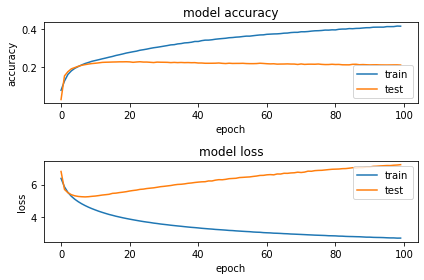

In [0]:
# Plot train and validation curves
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.subplot(2,1,2)
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.tight_layout()